In [1]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 📂DATA : 2 Classes

In [2]:
fold = 3

In [3]:
path = "/home/kannika/code/Rheology2023/Rheology_Blood/DataBlood_Viscosity_TrainML_3Fold_EMclass.csv"
data_feature = pd.read_csv(path)
print(data_feature.shape)
print("-"*100)
print(f"All Fold : {set(data_feature.fold)}")
## Split Train data Set
feature_train = data_feature[data_feature["fold"]!=fold].reset_index(drop=True)
print(f"Train Set : Fold ==> {set(feature_train.fold)}")
print("Train = ", feature_train.shape)
## Split Valid data Set
feature_valid = data_feature[data_feature["fold"]==fold].reset_index(drop=True)
print(f"Valiadtion Set : Fold ==> {set(feature_valid.fold)}")
print("Validation = ", feature_valid.shape)
## Print DataFrame
feature_valid.head()

(33, 11)
----------------------------------------------------------------------------------------------------
All Fold : {1, 2, 3}
Train Set : Fold ==> {1, 2}
Train =  (22, 11)
Valiadtion Set : Fold ==> {3}
Validation =  (11, 11)


,Unnamed: 0,Unnamed: 0.1,Code,classes,subclass,classes_binary,MCV,MCH,Hb,typeBEvsBM,fold
0,16,18,HN20,HN,No_Splenectomy,1.0,69.5,20.5,6.1,E,3
1,17,31,HN27,HN,Splenectomy,1.0,77.1,24.1,7.8,E,3
2,18,36,HN31,HN,No_Splenectomy,1.0,67.7,21.3,6.0,E,3
3,19,1,HN38,HN,No_Splenectomy,1.0,72.9,22.6,8.0,E,3
4,20,48,HN23,HN,Splenectomy,1.0,85.9,27.0,5.0,E,3


In [4]:
X_test = feature_valid[['MCV','MCH','Hb']]
y_test = feature_valid["typeBEvsBM"]
print(X_test.shape)
print(y_test.shape)
print(y_test[0])

(11, 3)
(11,)
E


In [5]:
print(len(set(y_test)))
print(set(y_test))

2
{'E', 'M'}


In [6]:
print("Counts of label 'BE': {}".format(sum(y_test=='E')))
print("Counts of label 'BM': {} \n".format(sum(y_test=='M')))

Counts of label 'BE': 8
Counts of label 'BM': 3 



## 🚀Load Model

In [7]:
nameclass = "typeBEvsBM_SmoteClasses"

In [8]:
#load model
import pickle

model_path = f"/media/tohn/HDD/rheology2023/ML_Model/Blood_Viscosity/{nameclass}/fold{fold}/RFModel_Blood_{nameclass}_fold{fold}.pkl"
print(f"[INFO]: Load Model from: {model_path}")
with open(model_path, 'rb') as file:
    model = pickle.load(file)

[INFO]: Load Model from: /media/tohn/HDD/rheology2023/ML_Model/Blood_Viscosity/typeBEvsBM_SmoteClasses/fold3/RFModel_Blood_typeBEvsBM_SmoteClasses_fold3.pkl


In [9]:
import numpy as np

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print(len(y_pred))
print(y_pred)

prob_list = list()
for i in range(0,len(y_prob)):
    result = y_prob[i]
    maxx = np.argmax(result)
    prob_i = result[maxx]
    prob_list.append(prob_i)
print(len(prob_list))

11
['E' 'M' 'E' 'M' 'M' 'E' 'E' 'M' 'E' 'M' 'E']
11


In [10]:
print(prob_list)

[0.8063571428571429, 0.5454967948717949, 0.7332321428571429, 0.6907021520146519, 0.595, 0.665687728937729, 0.5458333333333334, 0.9202021520146519, 0.9975, 0.5431009615384615, 0.9925]


In [11]:
feature_valid['Category'] = y_pred
feature_valid['Prob'] = prob_list
feature_valid.head()

,Unnamed: 0,Unnamed: 0.1,Code,classes,subclass,classes_binary,MCV,MCH,Hb,typeBEvsBM,fold,Category,Prob
0,16,18,HN20,HN,No_Splenectomy,1.0,69.5,20.5,6.1,E,3,E,0.806357
1,17,31,HN27,HN,Splenectomy,1.0,77.1,24.1,7.8,E,3,M,0.545497
2,18,36,HN31,HN,No_Splenectomy,1.0,67.7,21.3,6.0,E,3,E,0.733232
3,19,1,HN38,HN,No_Splenectomy,1.0,72.9,22.6,8.0,E,3,M,0.690702
4,20,48,HN23,HN,Splenectomy,1.0,85.9,27.0,5.0,E,3,M,0.595000


In [12]:
act = feature_valid['typeBEvsBM'].tolist()
pred = feature_valid['Category'].tolist()
#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
# confusion_matrix(act, pred)
cmat = confusion_matrix(act, pred)
print('Classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))
print("="*100)
print(classification_report(act, pred))#performance

Classifier accuracy = 45.45454545454545%
              precision    recall  f1-score   support

           E       0.67      0.50      0.57         8
           M       0.20      0.33      0.25         3

    accuracy                           0.45        11
   macro avg       0.43      0.42      0.41        11
weighted avg       0.54      0.45      0.48        11



Text(0.5, 21.5, 'Predicted label')

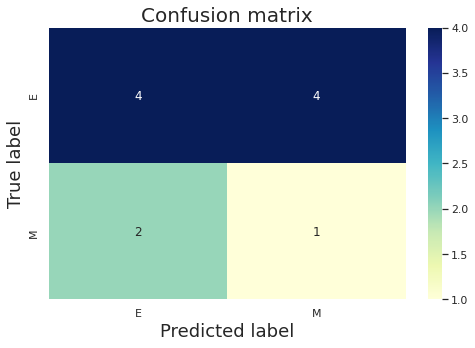

In [13]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

In [14]:
cm

array([[4, 4],
       [2, 1]])

In [15]:
tn, fp, fn, tp = confusion_matrix(act, pred).ravel()
print("True Negative (TN):", tn)
print("False Positive (FP):", fp)
print("False Negative (FN):", fn)
print("True Positive (TP):", tp)

True Negative (TN): 4
False Positive (FP): 4
False Negative (FN): 2
True Positive (TP): 1
